In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import os
from IPython.display import Image
from torchvision.utils import save_image

In [ ]:
fmnist = FashionMNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:01<00:00, 15987854.60it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273817.06it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4980344.63it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5842066.29it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [ ]:
img, label = fmnist[0]
torch.min(img), torch.max(img)

(tensor(-1.), tensor(1.))

Label: 9


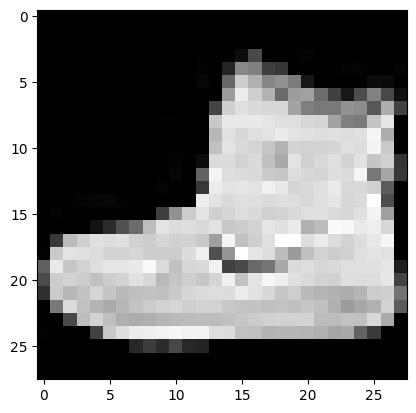

In [ ]:
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [ ]:
batch_size = 100
data_loader = DataLoader(fmnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([6, 8, 7, 4, 7, 3, 1, 4, 5, 2, 0, 7, 5, 0, 7, 7, 5, 4, 1, 1, 2, 9, 8, 3,
        7, 0, 9, 6, 6, 9, 3, 2, 6, 6, 4, 6, 4, 4, 8, 0, 7, 2, 2, 2, 3, 7, 7, 6,
        6, 4, 8, 6, 3, 9, 0, 4, 3, 0, 8, 2, 7, 1, 7, 3, 5, 1, 4, 4, 6, 2, 8, 1,
        3, 1, 3, 1, 0, 4, 5, 4, 4, 0, 5, 6, 7, 0, 7, 1, 3, 7, 9, 7, 0, 1, 5, 8,
        2, 6, 9, 8])


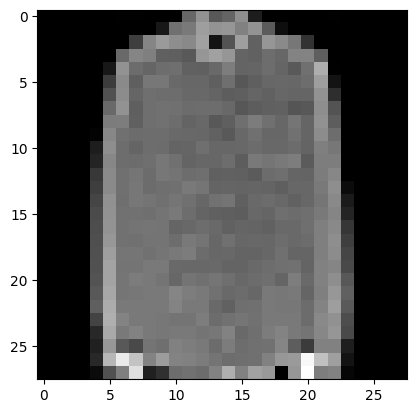

In [ ]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0],cmap='gray')
    print(label_batch)
    break

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
image_size = 784 #28x28 =784 (image dimensions)

In [ ]:
D = nn.Sequential(
    nn.Linear(image_size, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid())
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [ ]:
latent_size = 64

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, image_size),
    nn.Tanh())

In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

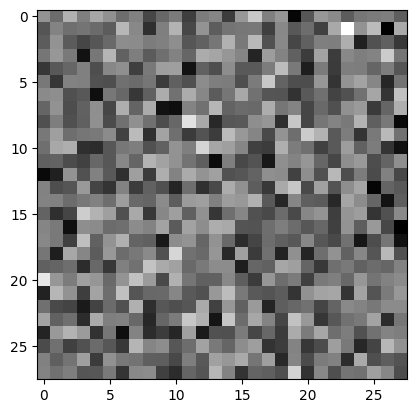

In [ ]:
plt.imshow(gen_imgs[0],cmap='gray') #noise

In [ ]:
G.to(device) #before y=G(torch.randn(2,latent_size)) gives an error saying it's n multiple devices

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [ ]:
criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [ ]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

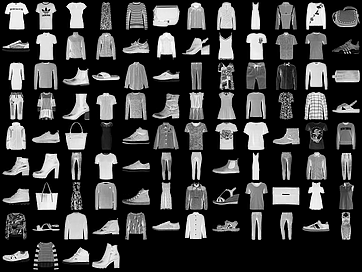

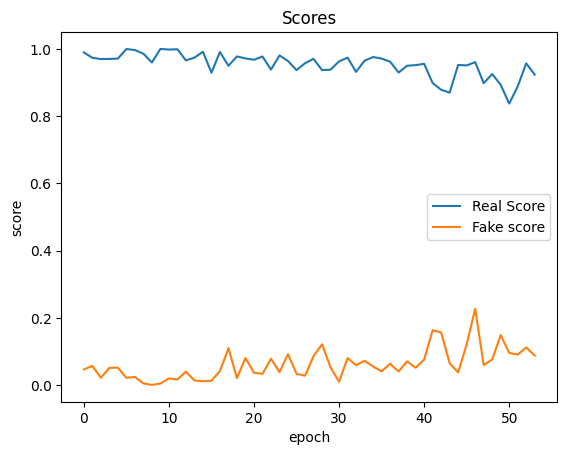

In [ ]:
#save real images
for images, _ in data_loader:
  plt.plot(real_scores, '-')
  plt.plot(fake_scores, '-')
  plt.xlabel('epoch')
  plt.ylabel('score')
  plt.legend(['Real Score', 'Fake score'])
  plt.title('Scores');
  break
images = images.reshape(images.size(0), 1, 28, 28)
save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=12)

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


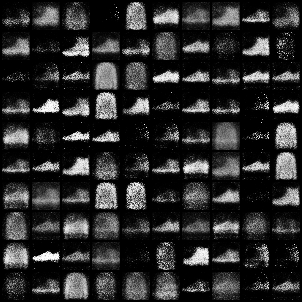

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.2550, g_loss: 5.0046, D(x): 0.89, D(G(z)): 0.06
Epoch [0/300], Step [400/600], d_loss: 0.4486, g_loss: 3.5182, D(x): 0.89, D(G(z)): 0.13
Epoch [0/300], Step [600/600], d_loss: 0.5199, g_loss: 3.0917, D(x): 0.85, D(G(z)): 0.13
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.4347, g_loss: 2.9234, D(x): 0.89, D(G(z)): 0.16
Epoch [1/300], Step [400/600], d_loss: 0.3601, g_loss: 3.3636, D(x): 0.94, D(G(z)): 0.19
Epoch [1/300], Step [600/600], d_loss: 0.3855, g_loss: 3.6022, D(x): 0.95, D(G(z)): 0.19
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.5927, g_loss: 4.8043, D(x): 0.81, D(G(z)): 0.02
Epoch [2/300], Step [400/600], d_loss: 0.3800, g_loss: 3.0440, D(x): 0.87, D(G(z)): 0.08
Epoch [2/300], Step [600/600], d_loss: 0.2276, g_loss: 4.3363, D(x): 0.93, D(G(z)): 0.09
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.3757, g_loss: 2.5289, D(x): 0.89, D(G(z)): 0.11
Epoch [3/300], Step [400/6

In [ ]:
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

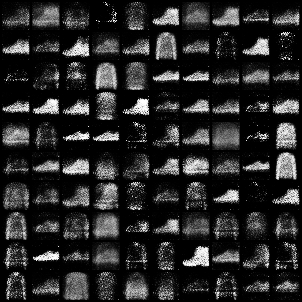

In [ ]:
Image('./samples/fake_images-0010.png')

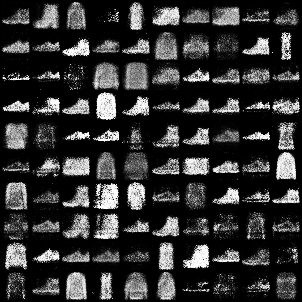

In [ ]:
Image('./samples/fake_images-0050.png')

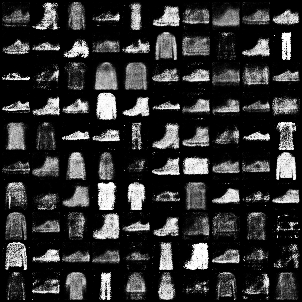

In [ ]:
Image('./samples/fake_images-0100.png')

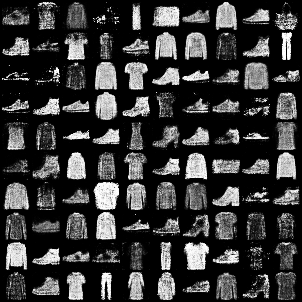

In [ ]:
Image('./samples/fake_images-0300.png')

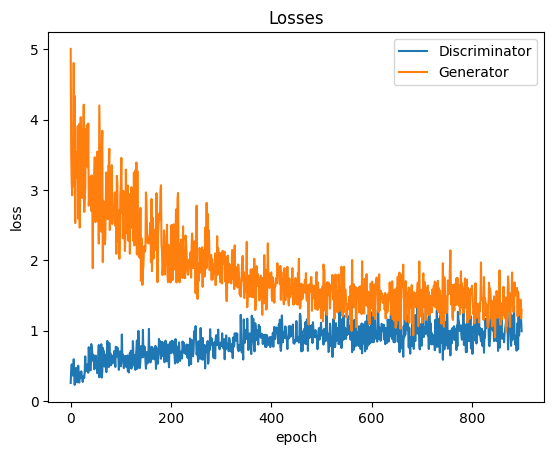

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

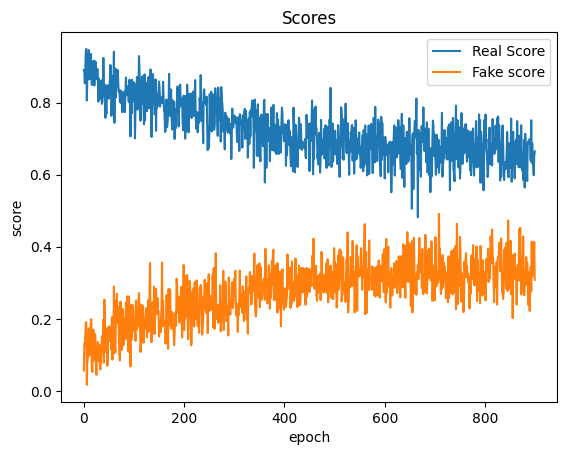

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');